In [333]:
# !pip install pandas_datareader

In [334]:
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [335]:
#Get the stock
ticker = 'SBUX'
stock ="Starbucks Corporation"
#  here we will use n  days historical data to predict next day closing
ts_points = 120
# train_data[0:60,0]  

today = datetime.today()
# start_date ='2016-01-01'
start_date = (today - timedelta(days=5*365) ).strftime('%Y-%m-%d')

# end_date   = today.strftime('%Y-%m-%d')
end_date = (today - timedelta(days=62) ).strftime('%Y-%m-%d')

stock_df = pdr.DataReader(ticker, data_source="yahoo", start=start_date, end=end_date)

In [336]:
# Date is an index but to be sure , let's sort
stock_df = stock_df.sort_index(ascending=True)
stock_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-11-01,53.209999,52.090000,53.139999,52.500000,15425800.0,47.644585
2016-11-02,53.459999,52.310001,52.340000,52.980000,10851700.0,48.080193
2016-11-03,53.000000,51.340000,52.990002,51.770000,21847300.0,46.982098
2016-11-04,53.740002,50.840000,51.430000,52.750000,21956800.0,47.871464
2016-11-07,54.680000,53.189999,53.500000,54.490002,14916800.0,49.450542
...,...,...,...,...,...,...
2021-08-24,115.849998,114.940002,115.389999,115.080002,3447300.0,115.080002
2021-08-25,115.989998,115.000000,115.589996,115.570000,3881500.0,115.570000
2021-08-26,115.769997,113.860001,115.620003,114.320000,5188200.0,114.320000


In [337]:
# check for nulls
stock_df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [338]:
# Get shape
stock_df.shape

(1215, 6)

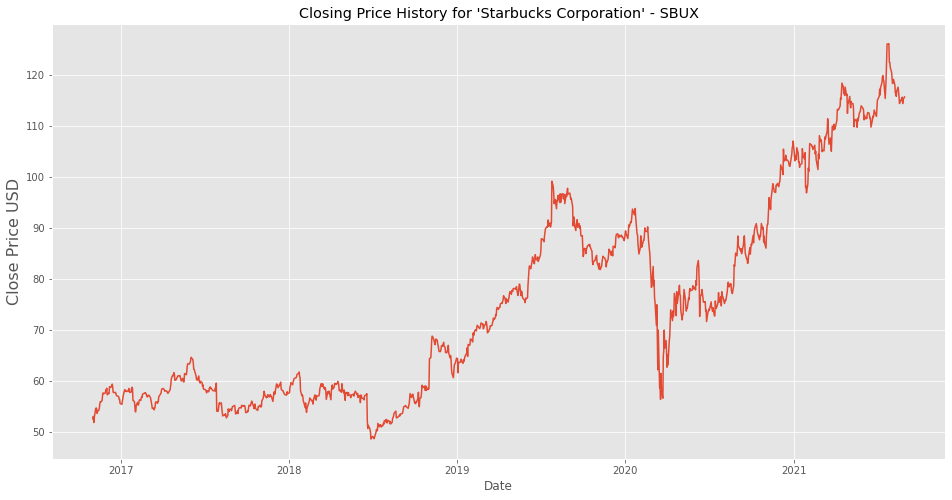

In [339]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(stock_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.savefig('../static/Images/his_'+ticker+'.png')
plt.show()

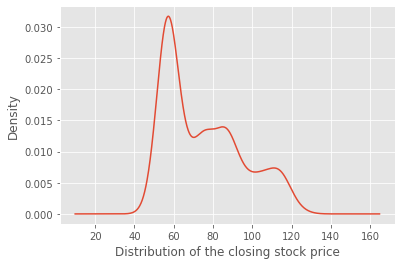

In [340]:
stock_df['Close'].plot.density()
plt.xlabel('Distribution of the closing stock price')
plt.savefig('../static/Images/den_'+ticker+'.png')
plt.show()

In [341]:
# DF with only close
TSdata_df = stock_df.filter(['Close'])
TSdata_df


,Close
Date,
2016-11-01,52.500000
2016-11-02,52.980000
2016-11-03,51.770000
2016-11-04,52.750000
2016-11-07,54.490002
...,...
2021-08-24,115.080002
2021-08-25,115.570000
2021-08-26,114.320000


In [342]:
TSdata_arr = TSdata_df.values # this creates an array of Close Price
TSdata_arr

array([[ 52.5       ],
       [ 52.97999954],
       [ 51.77000046],
       ...,
       [114.31999969],
       [115.12000275],
       [115.61000061]])

In [343]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

# ADF Test
result = adfuller(TSdata_arr, autolag='AIC')

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -0.288526
p-value: 0.927114
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to Reject Ho - Time Series is Non-Stationary


In [344]:
df2 = TSdata_df['Close'].diff().dropna().to_frame()
df2

,Close
Date,
2016-11-02,0.480000
2016-11-03,-1.209999
2016-11-04,0.980000
2016-11-07,1.740002
2016-11-08,0.129997
...,...
2021-08-24,-0.070000
2021-08-25,0.489998
2021-08-26,-1.250000


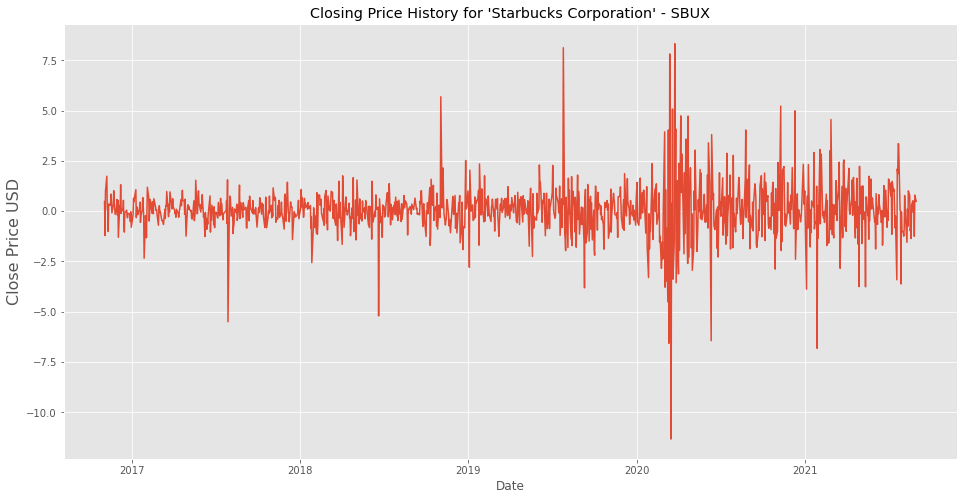

In [345]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(df2['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.savefig('../static/Images/diff_'+ticker+'.png')
plt.show()

In [346]:
# TSdata_arr = df2.filter(['Close']).values
# TSdata_arr

In [347]:
# Scale the Data
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(TSdata_arr)
# scaled_data

In [348]:
training_data_len = math.ceil(len(TSdata_arr) * 0.75)
training_data_len

912

In [349]:
# Created scaled training dataset
train_data = scaled_data[0:training_data_len]
train_data.shape

(912, 1)

In [350]:
# Split
X_train = []
y_train = []

for i in range(ts_points, len(train_data)):
    X_train.append(train_data[i-ts_points:i,0])
    y_train.append(train_data[i,0])
    # if i <= ts_points+3:
    #     print(X_train)
    #     print(y_train)
    #     print()


In [351]:
# convert X_train and y_train to numpy arrays for LSTM
X_train, y_train = np.array(X_train), np.array(y_train)

In [352]:
print (X_train.shape)
print (y_train.shape)

(792, 120)
(792,)


In [353]:
# LSTM network expects a 3D input (No_of_Samples, number of time steps, and number of features) no_of_features = 1 (Close)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(792, 120, 1)

In [354]:
training_data_len - ts_points

792

In [355]:
# hidden_nodes = int(2/3 * (X_train.shape[1] * 1))
# print(f"The number of hidden nodes is {hidden_nodes}.")

In [357]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 120, 50)           10400     
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [358]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [359]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size=64

os.makedirs("chk_points/", exist_ok=True)
chkpoint_path="chk_points/weights.{epoch}.hdf5"

# Create chk points
chkpt_callback = ModelCheckpoint(filepath=chkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

# chkpoint_path = "chk_points/cp-{epoch:04d}.ckpt"
# chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=chkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*batch_size)                    

# model.save_weights(chkpoint_path.format(epoch=0))    


In [360]:
# training_data_len
# scaled_data

In [361]:
# model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_split=0.43, callbacks=[chkpt_callback])
model.fit(X_train, y_train, batch_size=64 ,epochs=100)

Epoch 1/100
13/13 [==============================] - 3s 67ms/step - loss: 0.0136
Epoch 2/100
13/13 [==============================] - 1s 69ms/step - loss: 0.0037
Epoch 3/100
13/13 [==============================] - 1s 68ms/step - loss: 0.0030
Epoch 4/100
13/13 [==============================] - 1s 70ms/step - loss: 0.0024
Epoch 5/100
13/13 [==============================] - 1s 68ms/step - loss: 0.0023
Epoch 6/100
13/13 [==============================] - 1s 69ms/step - loss: 0.0020
Epoch 7/100
13/13 [==============================] - 1s 69ms/step - loss: 0.0019
Epoch 8/100
13/13 [==============================] - 1s 67ms/step - loss: 0.0018
Epoch 9/100
13/13 [==============================] - 1s 69ms/step - loss: 0.0018
Epoch 10/100
13/13 [==============================] - 1s 69ms/step - loss: 0.0014
Epoch 11/100
13/13 [==============================] - 1s 69ms/step - loss: 0.0016
Epoch 12/100
13/13 [==============================] - 1s 69ms/step - loss: 0.0016
Epoch 13/100
13/13 [=====

In [362]:
model.save('../assets/Model_'+ticker+'.h5')

In [363]:
# test_data = scaled_data[training_data_len:]

# Bring in the last 'ts_points' (120 values) from training set so when X_test is used to predict , predictions have same shape as Y_test
# The for loop starts with 'ts_points' that means the resultant array will have 120 less rows
test_data = scaled_data[training_data_len-ts_points:]



In [364]:
X_test = []
y_test = TSdata_arr[training_data_len:]
for i in range(ts_points, len(test_data)):
    X_test.append(test_data[i-ts_points:i,0])


In [365]:
# convert the data to a numpy array to use it in LSTM MODEL
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1], 1))

In [366]:
from sklearn.metrics import mean_squared_error

In [367]:
# Models predicted price for X_train
predictions_tr = model.predict(X_train)
predictions_tr = scaler.inverse_transform(predictions_tr)

y_train_tr =  scaler.inverse_transform(y_train.reshape(-1,1))
rmse_tr = math.sqrt(mean_squared_error(y_train_tr, predictions_tr))
rmse_tr

1.557529232564501

In [368]:
# Models predicted price for X_test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [369]:
y_test.shape, predictions.shape

((303, 1), (303, 1))

In [370]:
# RMSE to check accuracy

rmse = math.sqrt(mean_squared_error(y_test, predictions))
rmse

2.2998428272961444

In [371]:
# Plot
train = TSdata_df[:training_data_len]
actual = TSdata_df[training_data_len:]
actual['Predictions'] = predictions
actual

<ipython-input-371-bb86776ae978>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Predictions'] = predictions


,Close,Predictions
Date,,
2020-06-18,76.309998,76.386444
2020-06-19,75.400002,76.401100
2020-06-22,75.400002,76.063400
2020-06-23,75.489998,75.719048
2020-06-24,73.639999,75.512680
...,...,...
2021-08-24,115.080002,112.146179
2021-08-25,115.570000,112.231567
2021-08-26,114.320000,112.587250


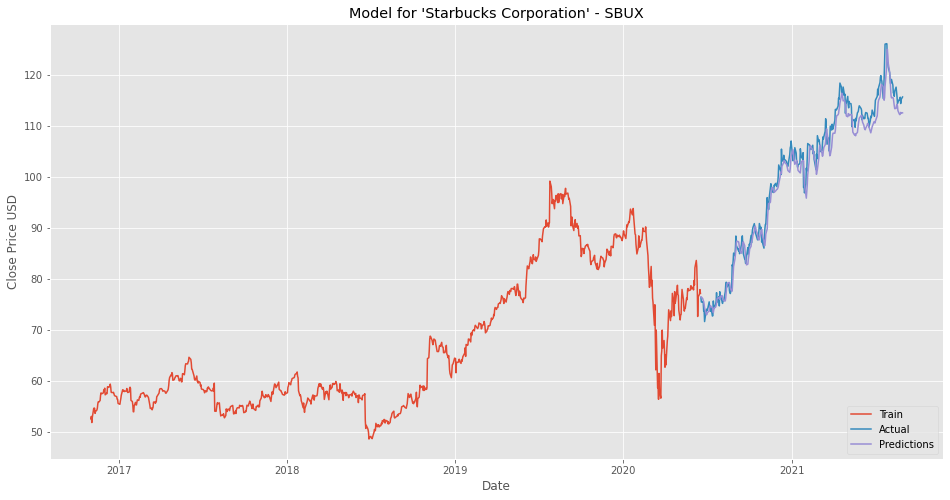

In [372]:
plt.figure(figsize=(16,8))
plt.title(f"Model for '{stock}' - {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price USD")
plt.plot(train['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.savefig('../static/Images/'+ticker+'.png')
plt.show()

# TEST

In [373]:
# for predictions add 100 extra days to make sure it has more than ts_points to make up for missing days (weekends and holidays)

fetch_days = ts_points + 100    

sd =  today - timedelta(days=fetch_days)
sd = sd.strftime('%Y-%m-%d')

ed = today.strftime('%Y-%m-%d')
ed

next_day = (today + timedelta(days=1) ).strftime('%Y-%m-%d')
# next_day

In [374]:
# get the quote
quote = pdr.DataReader(ticker, data_source="yahoo", start=sd, end=ed)
new_df = quote.filter(['Close'])
last_n_days = ts_points
last_n_days_arr = new_df[-last_n_days:].values 

In [375]:
last_n_days_scaled = scaler.transform(last_n_days_arr)
X_test = []
X_test.append(last_n_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))


In [376]:
##########################loading saved model ###############################
new_model = tf.keras.models.load_model('../assets/Model_'+ticker+'.h5')

# Check its architecture
new_model.summary()
nmpred_price = new_model.predict(X_test)
nmpred_price = scaler.inverse_transform(nmpred_price)
nmpred_price = nmpred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {nmpred_price:.4f}")

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 120, 50)           10400     
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Predicted Closing price for 'Starbucks Corporation' on 2021-11-01 is 108.5836


In [377]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = pred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {pred_price:.4f}")

Predicted Closing price for 'Starbucks Corporation' on 2021-11-01 is 108.5836


In [378]:
# verify
d1 = today - timedelta(days=5)
d1 = d1.strftime('%Y-%m-%d')

quote2 = pdr.DataReader(ticker, data_source="yahoo", start=d1)
quote2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-10-26,115.279999,114.250000,114.919998,114.919998,5948000,114.919998
2021-10-27,115.570000,113.080002,115.570000,113.510002,5853900,113.510002
2021-10-28,114.599998,112.459999,113.739998,113.199997,7697600,113.199997
2021-10-29,107.989998,104.019997,107.500000,106.070000,27401600,106.070000
